<a href="https://colab.research.google.com/github/adolfolh/casuality-classification/blob/main/data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **`2.` DATA CLEANING & PREPARATION** 🧽

## **Steps taken to clean and prepare this data:**

1. Checking for duplicate data and removing them
2. Remove unnecessary rows/columns
3. Feature selection

In [ ]:
# Run to download data
!wget https://github.com/adolfolh/casuality-classification/raw/main/data/casualties-2020.csv

In [26]:
# Import libraries
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif as MIC
from sklearn.tree import DecisionTreeClassifier as DTC

In [27]:
# Import data
raw_data = pd.read_csv("casualties-2020.csv", dtype={
    "accident_index" : "string",
    "accident_reference" : "string",
    "casualty_class" : int,
    "sex_of_casualty" : int,
    "age_band_of_casualty" : int,
    "casualty_severity" : int,
    "pedestrian_location" : int,
    "pedestrian_movement" : int,
    "car_passenger" : int,
    "bus_or_coach_passenger" : int,
    "pedestrian_road_maintenance_worker" : int,
    "casualty_type" : int,
    "casualty_home_area_type" : int,
    "casualty_imd_decile" : int
    })

In [28]:
raw_data.head()

,accident_index,accident_year,accident_reference,vehicle_reference,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
0,2020010219808,2020,010219808,1,1,3,1,31,6,3,9,5,0,0,0,0,1,4
1,2020010220496,2020,010220496,1,1,3,2,2,1,3,1,1,0,0,0,0,1,2
2,2020010220496,2020,010220496,1,2,3,2,4,1,3,1,1,0,0,0,0,1,2
3,2020010228005,2020,010228005,1,1,3,1,23,5,3,5,9,0,0,0,0,1,3
4,2020010228006,2020,010228006,1,1,3,1,47,8,2,4,1,0,0,0,0,1,3


### 1. Checking for duplicate data and removing them

In [29]:
dupl = raw_data.duplicated()
dupl.groupby(dupl).size()

False    115584
dtype: int64

There is no duplicate data in the dataset.

### 2. Remove unnecessary rows/columns

In [30]:
# Delete reference/index, year and age band columns.
small_df = raw_data.drop(['accident_index','accident_year','accident_reference','vehicle_reference','casualty_reference','age_band_of_casualty'], axis=1, inplace=False)

In [31]:
# Delete unwanted rows
small_df.drop(small_df[small_df['age_of_casualty'] == -1].index, axis=0, inplace=True) # dropped rows where age was not known
small_df.drop(small_df[(small_df['sex_of_casualty'] == -1) | (small_df['sex_of_casualty'] == 9) ].index, axis=0, inplace=True) # dropped rows where sex was not known
small_df.drop(small_df[(small_df['pedestrian_location'] == -1) | (small_df['pedestrian_location'] == 10) ].index, axis=0, inplace=True) # dropped rows where pedestrian location was not known
small_df.drop(small_df[(small_df['pedestrian_movement'] == -1) | (small_df['pedestrian_movement'] == 9) ].index, axis=0, inplace=True) # dropped rows where pedestrian movement was not known
small_df.drop(small_df[(small_df['car_passenger'] == -1) | (small_df['car_passenger'] == 9) ].index, axis=0, inplace=True) # dropped rows where car passenger was not known
small_df.drop(small_df[(small_df['bus_or_coach_passenger'] == -1) | (small_df['bus_or_coach_passenger'] == 9) ].index, axis=0, inplace=True) # dropped rows where bus or coach passenger was not known
small_df.drop(small_df[(small_df['pedestrian_road_maintenance_worker'] == -1) | (small_df['pedestrian_road_maintenance_worker'] == 2)].index, axis=0, inplace=True) # dropped rows where pedestrian_road_maintenance_worker was not known
small_df.drop(small_df[small_df['casualty_imd_decile'] == -1].index, axis=0, inplace=True) # dropped rows where casualty_imd_decile was not known
small_df.drop(small_df[small_df['casualty_home_area_type'] == -1].index, axis=0, inplace=True) # dropped rows where casualty_home_area_type was not known

for x in [103,104,105,106,108,109,110,113]:
  small_df.drop(small_df[small_df['casualty_type'] == x].index, axis=0, inplace=True) # dropped rows where casualty type was not known or useless

In [32]:
for col in small_df.columns:
  print(f'Unique categories in {col}: {len(small_df[col].unique())}')

Unique categories in casualty_class: 3
Unique categories in sex_of_casualty: 2
Unique categories in age_of_casualty: 100
Unique categories in casualty_severity: 3
Unique categories in pedestrian_location: 10
Unique categories in pedestrian_movement: 9
Unique categories in car_passenger: 3
Unique categories in bus_or_coach_passenger: 5
Unique categories in pedestrian_road_maintenance_worker: 2
Unique categories in casualty_type: 21
Unique categories in casualty_home_area_type: 3
Unique categories in casualty_imd_decile: 10


### 3. Feature selection

The two most commonly used feature selection methods for categorical input data when the target variable is also categorical (e.g. classification predictive modeling) are the chi-squared statistic and the mutual information statistic.


In [33]:
X = small_df.loc[:, small_df.columns != 'casualty_severity']
y = small_df.loc[:, small_df.columns == 'casualty_severity']

In [34]:
chi_scores = chi2(X,y)
chi_scores # here first array represents chi square values and second array represents p-values

(array([8.31037816e+01, 1.09544400e+02, 6.53382332e+03, 3.96575061e+03,
        2.00603489e+03, 3.66238128e+02, 1.39823701e+02, 1.14363197e+00,
        1.67206367e+03, 1.13835180e+02, 1.94394718e+02]),
 array([9.00001259e-19, 1.63205886e-24, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.96757026e-80, 4.34179367e-31, 5.64499385e-01,
        0.00000000e+00, 1.90987379e-25, 6.13371256e-43]))

In [35]:
p_values = pd.Series(chi_scores[1],index = X.columns)
p_values.sort_values(ascending = False , inplace = True)

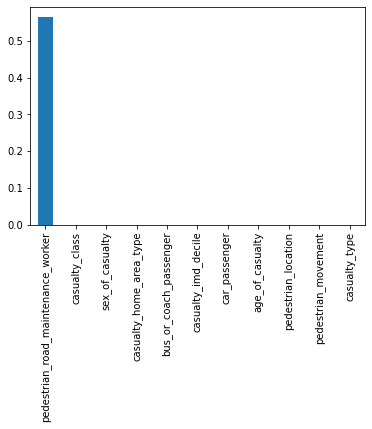

In [36]:
p_values.plot.bar()

We will drop pedestrian_road_maintenance_worker as it shows a large p-value in comparaison to the rest of the features. Since the rest of the variables have low p-value, it means they are independent of the respone and can be considered for model training.


In [37]:
fs_df = small_df.drop(['pedestrian_road_maintenance_worker'], axis=1, inplace=False)

In [38]:
mi_score = MIC(X,y.values.ravel())
print(mi_score) # represents MI score for all features

[0.01337615 0.01201755 0.00351811 0.00403361 0.00478192 0.00271058
 0.         0.         0.03375692 0.01217353 0.00194885]


### 4. Splitting data

Build 3 train data and test datasets and review which is better for this project.

Dataset 1 with no MI score curation, names marked with _1. Note that all three datasets will use the same y_train and y_test. So, no need to separate target data.

In [ ]:
X_train_1, X_test_1, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

Dataset 2 with features have MI scores larger than 0.002

In [40]:
mi_score_selected_index_1 = np.where(mi_score > 0.002)[0]
X_2 = X.iloc[:,mi_score_selected_index_1]

In [41]:
X_train_2, X_test_2, y_train, y_test = train_test_split(X_2, y, test_size=0.2, random_state=8)

Dataset 3 with features have Mi scores less than 0.002

In [44]:
mi_score_selected_index_2 = np.where(mi_score < 0.002)[0]
X_3 = X.iloc[:,mi_score_selected_index_2]

In [45]:
X_train_3, X_test_3, y_train, y_test = train_test_split(X_3, y, test_size=0.2, random_state=8)

Compare the 3 datasets with the Decision Tree classifier

In [46]:
model_1 = DTC().fit(X_train_1,y_train)
model_2 = DTC().fit(X_train_2,y_train)
model_3 = DTC().fit(X_train_3,y_train)
score_1 = model_1.score(X_test_1,y_test)
score_2 = model_2.score(X_test_2,y_test)
score_3 = model_3.score(X_test_3,y_test)
print(f"Dataset 1 score: {score_1}\nDataset 2 score: {score_2}\nDataset 3 score: {score_3}")

Dataset 1 score: 0.7609746172236634
Dataset 2 score: 0.7989216135103515
Dataset 3 score: 0.8148430744188413


The results show we should keep all the original features.

## **Download dataframe**

In [47]:
clean_df = fs_df.copy()
clean_df.reset_index(inplace=True)
clean_df.drop(['index'], axis=1, inplace=True)

In [48]:
X_train_1.to_csv(r'X_train.csv')
X_test_1.to_csv(r'X_test.csv')
y_train.to_csv(r'y_train.csv')
y_test.to_csv(r'y_test.csv')
clean_df.to_csv(r'clean-casualties-2020.csv')